<a href="https://colab.research.google.com/github/juno-yuu/COVID-Vaccine-and-Biotech-industry/blob/Erin/Machine_Learning_Final_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotly_express
!pip install linearmodels
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import time
import plotly_express as px
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
from linearmodels.panel import PanelOLS, FamaMacBeth
from patsy              import dmatrices
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from fbprophet import Prophet
import pmdarima.arima as pm
import seaborn as sns 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
init_notebook_mode(connected=True)
import warnings
import os
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_csv("/content/drive/MyDrive/MFE 431 DAML /us_state_vaccinations.csv")
state = pd.read_csv("/content/drive/MyDrive/MFE 431 DAML /world_country_and_usa_states_latitude_and_longitude_values.csv")[['usa_state','usa_state_code']].dropna()
df = df.merge(state, left_on='location', right_on='usa_state')
df=df.drop(["usa_state"],axis=1)
df['daily_vaccinations_lagged'] = df['daily_vaccinations'].shift(1)

In [ ]:
# data fill with last value
df=df.fillna(method='ffill')
df=df.fillna(0) # if no preceding value, fill na
# check location value
df.location.unique() #get all state variable


array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'North Carolina', 'North Dakota',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [ ]:
df['date']=pd.to_datetime(df['date'])

#determine the date range
print("start date: ",df.date.min())
print("latest date: ",df.date.max())

#number of vaccination days
dates_range_length = len(pd.date_range(df.date.min(), df.date.max()))
print("The date range equals ",dates_range_length," days.")

start date:  2021-01-12 00:00:00
latest date:  2021-05-16 00:00:00
The date range equals  125  days.


In [ ]:
#add month to data frame
df['month'] = df.date.dt.month
#Date by Week Number
df['week'] = df.date.dt.week

# Data Visualization

In [ ]:
#Month
df_month = df.groupby(['usa_state_code','month']).daily_vaccinations.sum().reset_index()


In [ ]:
#Daily corona vaccinations on monthly basis
fig1 = px.choropleth(df_month,locations=df_month['usa_state_code'],color=df_month['daily_vaccinations'],
                     color_continuous_scale='YlOrRd',locationmode='USA-states',scope='usa',animation_frame=df_month['month'],
                     title="Vaccinations in the USA on monthly basis",labels={'daily_vaccinations':'Number of Vaccinations'})

fig1.show()


In [ ]:
#Week
df_week = df.groupby(['usa_state_code','week']).daily_vaccinations.sum().reset_index()
df_week = df_week.sort_values(by=['week','usa_state_code'])

In [ ]:
#Daily corona vaccinations on weekly basis
fig2 = px.choropleth(df_week,locations=df_week['usa_state_code'],color=df_week['daily_vaccinations'],
                     color_continuous_scale='YlOrRd',locationmode='USA-states',scope='usa',animation_frame=df_week['week'],
                     title="Vaccinations in the USA on weekly basis",labels={'daily_vaccinations':'Number of Vaccinations'})

fig2.show()

In [ ]:
df['day'] = df.date.dt.day
df_daily = df.groupby(['usa_state_code','day']).daily_vaccinations.sum().reset_index()

In [ ]:
#Daily corona vaccinations on monthly basis
fig3 = px.choropleth(df_daily,locations=df_daily['usa_state_code'],color=df_daily['daily_vaccinations'],
                     color_continuous_scale='YlOrRd',locationmode='USA-states',scope='usa',animation_frame=df_daily['day'],
                      title="Vaccinations in the USA on daily basis",labels={'daily_vaccinations':'Number of Vaccinations'})

fig3.show()

In [ ]:
def plot_gb_time_series(df, ts_name, gb_name, value_name, figsize=(20,7), title=None):
    '''
    Runs groupby on Pandas dataframe and produces a time series chart.

    Parameters:
    ----------
    df : Pandas dataframe
    ts_name : string
        The name of the df column that has the datetime timestamp x-axis values.
    gb_name : string
        The name of the df column to perform group-by.
    value_name : string
        The name of the df column for the y-axis.
    figsize : tuple of two integers
        Figure size of the resulting plot, e.g. (20, 7)
    title : string
        Optional title
    '''
    xtick_locator = mdates.DayLocator(interval=1)
    xtick_dateformatter = mdates.DateFormatter('%m/%d/%Y')
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([gb_name]):
        ax = grp.plot(ax=ax, kind='line', x=ts_name, y=value_name, label=key, marker='o')
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_dateformatter)
    ax.autoscale_view()
    ax.legend(loc='upper left')
    _ = plt.xticks(rotation=90, )
    _ = plt.grid()
    _ = plt.xlabel('')
    _ = plt.ylim(0, df[value_name].max() * 1.25)
    _ = plt.ylabel(value_name)
    if title is not None:
        _ = plt.title(title)
    _ = plt.show()

In [ ]:
df

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,usa_state_code,daily_vaccinations_lagged,month,week,day
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207,AL,NaN,1,2,12
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222,AL,NaN,1,2,13
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212,AL,5906.0,1,2,14
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226,AL,7083.0,1,2,15
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN,AL,7478.0,1,2,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6370,2021-05-12,Wyoming,374624.0,491255.0,202711.0,29.92,64.73,173179.0,35.03,84.88,1287.0,1639.0,2832.0,0.763,WY,1734.0,5,19,12
6371,2021-05-13,Wyoming,374754.0,491795.0,202831.0,29.95,64.75,173312.0,35.05,84.97,130.0,1623.0,2804.0,0.762,WY,1639.0,5,19,13
6372,2021-05-14,Wyoming,376441.0,492695.0,203422.0,30.14,65.04,174440.0,35.15,85.13,1687.0,1270.0,2194.0,0.764,WY,1623.0,5,19,14
6373,2021-05-15,Wyoming,378677.0,495435.0,204468.0,30.34,65.43,175581.0,35.33,85.60,2236.0,1272.0,2198.0,0.764,WY,1270.0,5,19,15


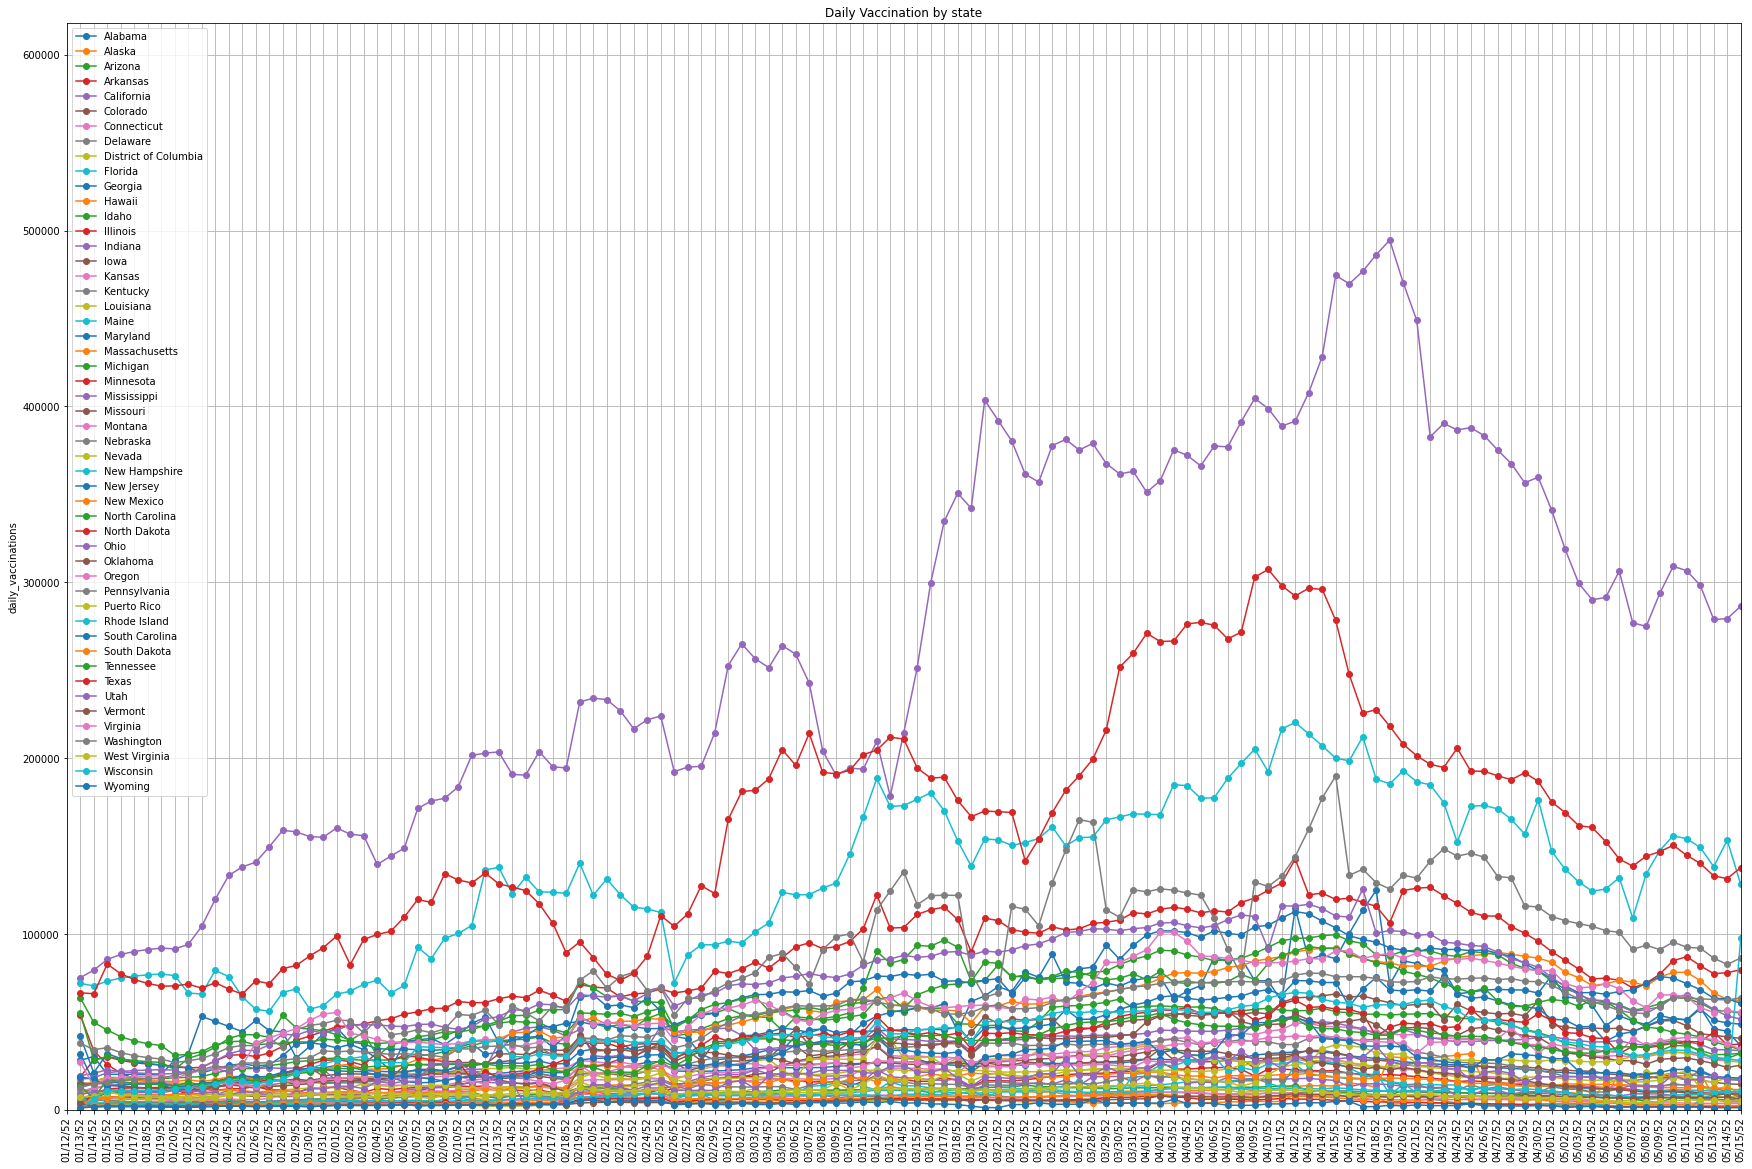

In [ ]:
plot_gb_time_series(df, 'date', 'location', 'daily_vaccinations',
                    figsize=(30, 20), title="Daily Vaccination by state")

In [ ]:
#define FMB regreesion
def fmreg(data,formula):
  return smf.ols(formula,data=data).fit().params[:]

# define output of the regression
def fm_summary(p):
  s = p.describe().T
  s['std_error'] = s['std']/np.sqrt(s['count'])
  s['tstat'] = s['mean']/s['std_error']
  s['Sharpe Ratio'] = s['mean']/s['std']
  return s[['mean','std','tstat','Sharpe Ratio']]

In [ ]:
data_panel = df.copy()
data_panel['date'] = pd.to_datetime(data_panel['date'], format='%Y-%m-%d', errors='ignore')
data_panel = data_panel.set_index(['location', 'date'])

In [ ]:

dv_panel = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged', data = data_panel).fit()
dv_panel.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.9911
Estimator:,PanelOLS,R-squared (Between):,0.9999
No. Observations:,6273,R-squared (Within):,0.9556
Date:,"Thu, May 27 2021",R-squared (Overall):,0.9911
Time:,23:05:51,Log-likelihood,-6.212e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6.981e+05
Entities:,51,P-value,0.0000
Avg Obs:,123.00,Distribution:,"F(1,6271)"
Min Obs:,123.00,,
Max Obs:,123.00,F-statistic (robust):,6.981e+05


In [ ]:
# cluster by time and location
dv_panel = PanelOLS.from_formula(formula = 'daily_vaccinations ~ 1 + daily_vaccinations_lagged', data = data_panel).fit(cov_type = 'clustered', cluster_entity = True, Cluster_time = True)
dv_panel.summary

Dep. Variable:,daily_vaccinations,R-squared:,0.9911
Estimator:,PanelOLS,R-squared (Between):,0.9999
No. Observations:,6273,R-squared (Within):,0.9556
Date:,"Thu, May 27 2021",R-squared (Overall):,0.9911
Time:,23:05:53,Log-likelihood,-6.212e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,6.981e+05
Entities:,51,P-value,0.0000
Avg Obs:,123.00,Distribution:,"F(1,6271)"
Min Obs:,123.00,,
Max Obs:,123.00,F-statistic (robust):,2.992e+05


In [ ]:
data_panel

total_vaccinations  total_distributed  ...  week  day
location date                                               ...           
Alabama  2021-01-12             78134.0           377025.0  ...     2   12
         2021-01-13             84040.0           378975.0  ...     2   13
         2021-01-14             92300.0           435350.0  ...     2   14
         2021-01-15            100567.0           444650.0  ...     2   15
         2021-01-16                 NaN                NaN  ...     2   16
...                                 ...                ...  ...   ...  ...
Wyoming  2021-05-12            374624.0           491255.0  ...    19   12
         2021-05-13            374754.0           491795.0  ...    19   13
         2021-05-14            376441.0           492695.0  ...    19   14
         2021-05-15            378677.0           495435.0  ...    19   15
         2021-05-16            378799.0           495435.0  ...    19   16

[6375 rows x 17 columns]

In [ ]:
manu = pd.read_csv("https://raw.githubusercontent.com/xinyanz-erin/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv", index_col = 1)

In [ ]:
#Pfizer
pfizer = manu.loc[(manu.vaccine =="Pfizer/BioNTech") & (manu.location =="United States")]
pfizer.rename(columns={'total_vaccinations': 'total_vaccinations_pfizer'}, inplace=True)
#Moderna
moderna = manu.loc[(manu.vaccine =="Moderna") & (manu.location =="United States")]
moderna.rename(columns={'total_vaccinations': 'total_vaccinations_moderna'}, inplace=True)
#J&J
jj = manu.loc[(manu.vaccine =="Johnson&Johnson") & (manu.location =="United States")]
jj.rename(columns={'total_vaccinations': 'total_vaccinations_jj'}, inplace=True)

In [ ]:
pfizer

,location,vaccine,total_vaccinations_pfizer
date,,,
2021-01-12,United States,Pfizer/BioNTech,5488697
2021-01-13,United States,Pfizer/BioNTech,6025872
2021-01-15,United States,Pfizer/BioNTech,7153268
2021-01-19,United States,Pfizer/BioNTech,8874811
2021-01-20,United States,Pfizer/BioNTech,9281063
...,...,...,...
2021-05-22,United States,Pfizer/BioNTech,153075845
2021-05-23,United States,Pfizer/BioNTech,154119424
2021-05-24,United States,Pfizer/BioNTech,154856445


In [ ]:
df_us = df.groupby('date').sum()
df_join = pd.concat([df_us,pfizer,moderna,jj],axis=0,keys=['date'])
df_join

total_vaccinations  total_distributed  ...  week  day
     date                                               ...           
date 2021-01-12           8286367.0         24477100.0  ...   102  612
     2021-01-13           9147820.0         25816725.0  ...   102  663
     2021-01-14           9883346.0         26936850.0  ...   102  714
     2021-01-15          10878843.0         27352275.0  ...   102  765
     2021-01-16                 0.0                0.0  ...   102  816
...                             ...                ...  ...   ...  ...
     2021-05-12         245759817.0        315976690.0  ...   969  612
     2021-05-13         247569325.0        317764720.0  ...   969  663
     2021-05-14         249275010.0        320305620.0  ...   969  714
     2021-05-15         251493868.0        322766780.0  ...   969  765
     2021-05-16         254052799.0        322766780.0  ...   969  816

[125 rows x 16 columns]

## Train_test_split


In [ ]:
sample_n =100
X = df.daily_vaccinations_lagged
y = df.daily_vaccinations
train_X,test_X = X[:sample_n],X[sample_n:]
train_y,test_y = y[:sample_n],y[sample_n:]

In [ ]:
import datetime
import operator 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
cols = confirmed_df.keys()

In [ ]:
confirmed = pd.concat([confirmed_df.loc[:, cols[6]],confirmed_df.loc[:, cols[11]:cols[-1]]],axis = 1)
us_cases = []
for i in dates:
    confirmed_sum = confirmed[i].sum()
    
    # confirmed, deaths, recovered, and active
    us_cases.append(confirmed_sum)

us_cases = np.array(us_cases).reshape(-1, 1)
dates = confirmed.keys()
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [ ]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[10:], us_cases[10:], test_size=0.2, shuffle=False)

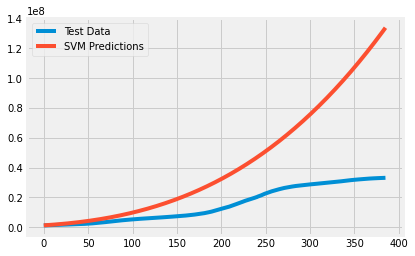

In [ ]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(list(map(int,y_test_confirmed)) )
plt.plot(list(map(int,svm_test_pred)) )
plt.legend(['Test Data', 'SVM Predictions'])

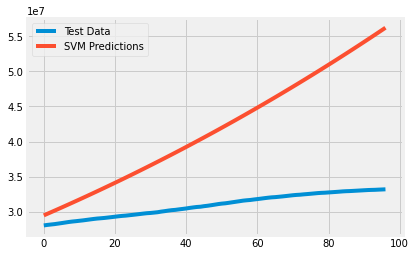

In [ ]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(list(map(int,y_test_confirmed)) )
plt.plot(list(map(int,svm_test_pred)) )
plt.legend(['Test Data', 'SVM Predictions'])

In [201]:
data = pd.read_csv('/content/drive/MyDrive/MFE 431 DAML /Pharmaceutical companies on the stock exchange in 2020.csv', index_col=0, header=[0,1], engine='python')

In [198]:
import pandas as pd
import math
from pandas_datareader import data, wb
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.widgets import TextBox

In [202]:
data.index = pd.to_datetime(data.index)
data.head()

Companies      PFIZER                        ...         JNJ                        
HLOCVAcV         High        Low       Open  ...        Open       Close   Adj Close
Date                                         ...                                    
2020-01-02  37.333965  36.888046  37.286530  ...  145.869995  145.970001  140.350418
2020-01-03  37.229603  36.688805  36.736244  ...  143.500000  144.279999  138.725479
2020-01-06  37.001900  36.717270  36.831120  ...  144.000000  144.100006  138.552414
2020-01-07  37.125237  36.698292  37.115749  ...  144.009995  144.979996  139.398529
2020-01-08  37.210625  36.764706  36.774193  ...  144.869995  144.960007  139.379318

[5 rows x 20 columns]

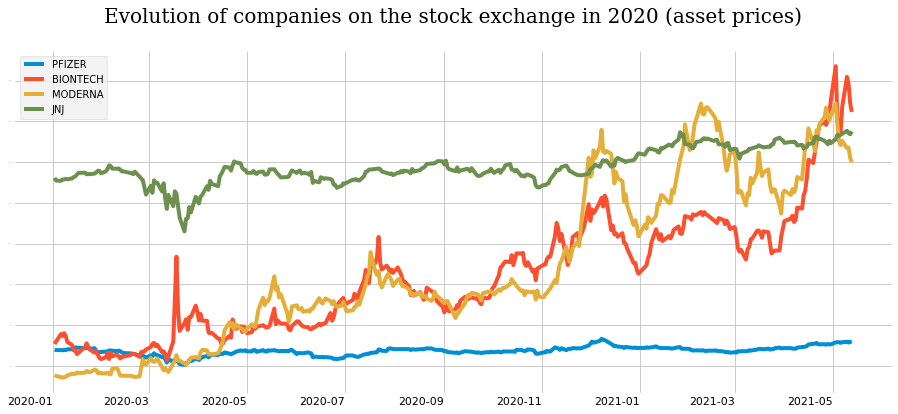

In [206]:
tickers = ['PFIZER','BIONTECH', 'MODERNA', 'JNJ']
for i in tickers:
  data[i]['Adj Close'].plot(figsize=(14,7), legend=True, label=i)
  plt.title('Evolution of companies on the stock exchange in 2020 (asset prices)\n', fontsize=20, fontfamily='serif')
  plt.box(False)
  plt.xticks(rotation=360, fontsize=11)
  plt.yticks(fontsize=0)
  plt.xlabel('')

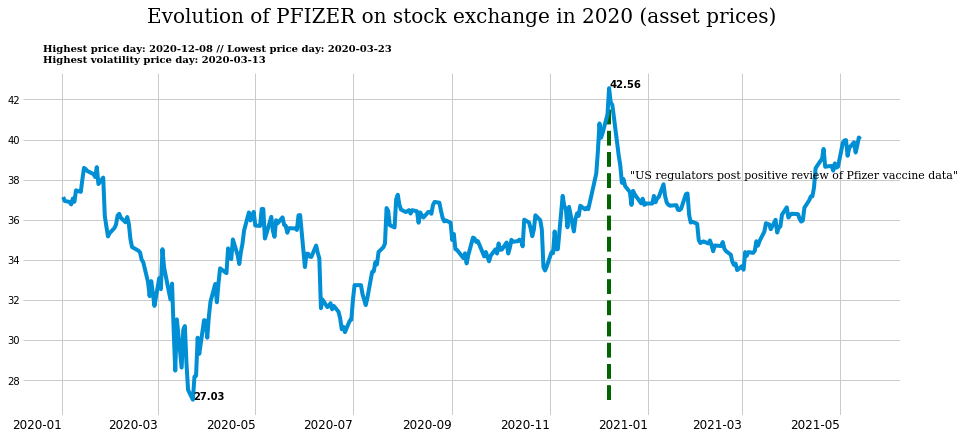

In [216]:
nl = '\n'
ax, fig = plt.subplots(1,1,figsize=(14,7))
data['PFIZER']['Close'].plot()
plt.title('Evolution of PFIZER on stock exchange in 2020-2021 (asset prices)\n\n', fontsize=20, fontfamily='serif')
plt.box(False)
ax.text(0.1,0.9,f'Highest price day: {str(data["PFIZER"]["Close"].idxmax())[:10]} // Lowest price day: {str(data["PFIZER"]["Close"].idxmin())[:10]}\nHighest volatility price day: {str(data["PFIZER"]["Close"].pct_change().idxmax())[:10]}',fontweight='bold', fontfamily='serif')
plt.annotate(f'{data["PFIZER"]["Close"].max():.2f}',(mdates.date2num(data["PFIZER"]["Close"].idxmax()),data["PFIZER"]["Close"].max()), fontweight='bold')
plt.annotate(f'{data["PFIZER"]["Close"].min():.2f}',(mdates.date2num(data["PFIZER"]["Close"].idxmin()),data["PFIZER"]["Close"].min()), fontweight='bold')
plt.vlines(x=f'{str(data["PFIZER"]["Close"].idxmax())}',ymin=data["PFIZER"]["Close"].min(), ymax=data["PFIZER"]["Close"].max(), color='darkgreen', linestyles='dashed')
plt.annotate('      "US regulators post positive review of Pfizer vaccine data"',(mdates.date2num(data["PFIZER"]["Close"].idxmax()),data["PFIZER"]["Close"].min()+11),fontfamily='serif', fontsize=11)
plt.xticks(rotation=360, fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('');

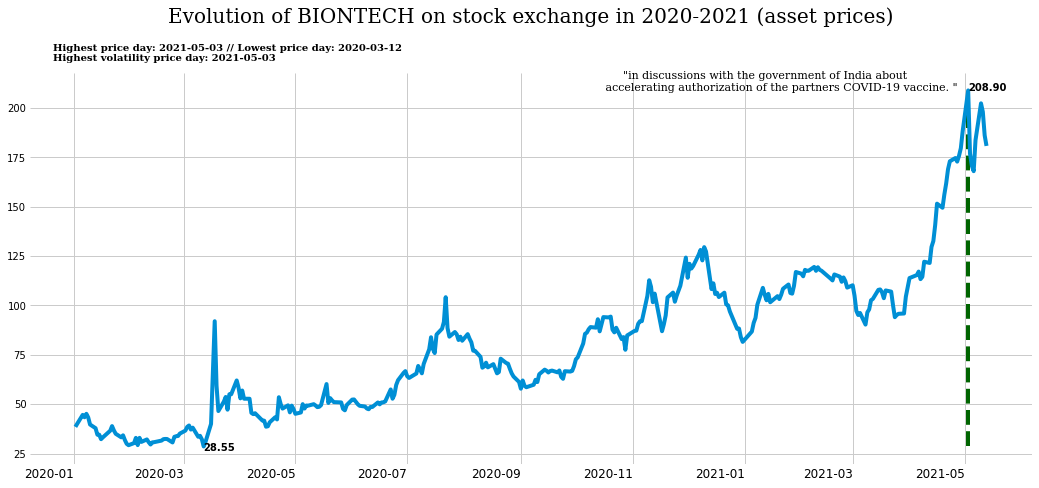

In [307]:
ax, fig = plt.subplots(1,1,figsize=(16,8))
data['BIONTECH']['Close'].plot()
plt.title('Evolution of BIONTECH on stock exchange in 2020-2021 (asset prices)\n\n', fontsize=20, fontfamily='serif')
plt.box(False)
ax.text(0.1,0.9,f'Highest price day: {str(data["BIONTECH"]["Close"].idxmax())[:10]} // Lowest price day: {str(data["BIONTECH"]["Close"].idxmin())[:10]}\nHighest volatility price day: {str(data["BIONTECH"]["Close"].idxmax())[:10]}',fontweight='bold', fontfamily='serif')
plt.annotate(f'{data["BIONTECH"]["Close"].max():.2f}',(mdates.date2num(data["BIONTECH"]["Close"].idxmax()),data["BIONTECH"]["Close"].max()), fontweight='bold')
plt.annotate(f'{data["BIONTECH"]["Close"].min():.2f}',(mdates.date2num(data["BIONTECH"]["Close"].idxmin()),data["BIONTECH"]["Close"].min()-2), fontweight='bold')
plt.vlines(x=f'{str(data["BIONTECH"]["Close"].idxmax())}',ymin=data["BIONTECH"]["Close"].min(), ymax=data["BIONTECH"]["Close"].max(), color='darkgreen', linestyles='dashed')
plt.annotate('      "in discussions with the government of India about\n accelerating authorization of the partners COVID-19 vaccine. "',(int(mdates.date2num(data["BIONTECH"]["Close"].idxmax())-200),data["BIONTECH"]["Close"].max()),fontfamily='serif', fontsize=11)
plt.xticks(rotation=360, fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('');

2020-5-3 https://www.fool.com/investing/2021/05/03/why-biontech-stock-is-jumping-today/

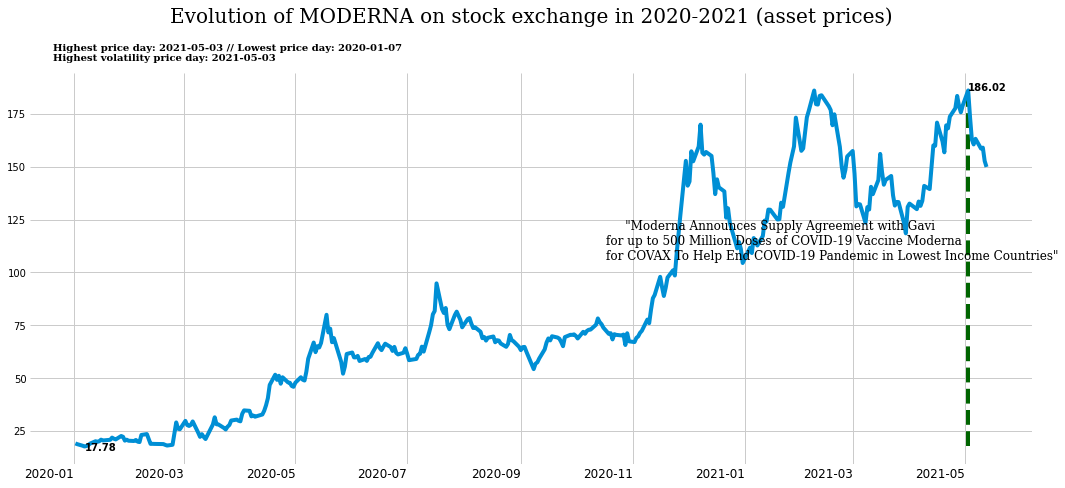

In [308]:
ax, fig = plt.subplots(1,1, figsize=(16,8))
data['MODERNA']['Close'].plot()
plt.title('Evolution of MODERNA on stock exchange in 2020-2021 (asset prices)\n\n', fontsize=20, fontfamily='serif')
plt.box(False)
ax.text(0.1,0.9, f'Highest price day: {str(data["MODERNA"]["Close"].idxmax())[:10]} // Lowest price day: {str(data["MODERNA"]["Close"].idxmin())[:10]}\nHighest volatility price day: {str(data["MODERNA"]["Close"].idxmax())[:10]}', fontfamily='serif',fontweight='bold',fontsize=10)
plt.annotate(f'{data["MODERNA"]["Close"].max():.2f}',(mdates.date2num(data["MODERNA"]["Close"].idxmax()),data["MODERNA"]["Close"].max()), fontweight='bold')
plt.annotate(f'{data["MODERNA"]["Close"].min():.2f}',(mdates.date2num(data["MODERNA"]["Close"].idxmin()),data["MODERNA"]["Close"].min()-2), fontweight='bold')
plt.vlines(x=f'{str(data["MODERNA"]["Close"].idxmax())}',ymin=data["MODERNA"]["Close"].min(), ymax=data["MODERNA"]["Close"].max(), color='darkgreen', linestyles='dashed')
plt.annotate('      "Moderna Announces Supply Agreement with Gavi\n for up to 500 Million Doses of COVID-19 Vaccine Moderna\n for COVAX To Help End COVID-19 Pandemic in Lowest Income Countries"',(mdates.date2num(data["MODERNA"]["Close"].idxmax())-200,data["MODERNA"]["Close"].max()-80),fontfamily='serif', fontsize=12)
plt.xticks(rotation=360, fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('');

TypeError: ignored

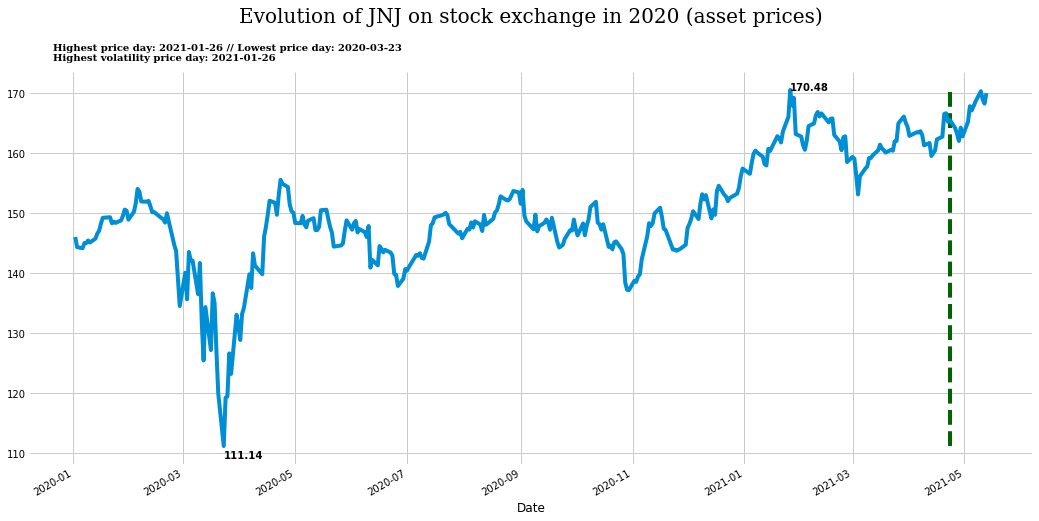

In [306]:
ax, fig = plt.subplots(1,1,figsize=(16,8))
data['JNJ']['Close'].plot()
plt.title('Evolution of JNJ on stock exchange in 2020-2021 (asset prices)\n\n', fontsize=20, fontfamily='serif')
plt.box(False)
ax.text(0.1,0.9,f'Highest price day: {str(data["JNJ"]["Close"].idxmax())[:10]} // Lowest price day: {str(data["JNJ"]["Close"].idxmin())[:10]}\nHighest volatility price day: {str(data["JNJ"]["Close"].idxmax())[:10]}',fontweight='bold', fontfamily='serif')
plt.annotate(f'{data["JNJ"]["Close"].max():.2f}',(mdates.date2num(data["JNJ"]["Close"].idxmax()),data["JNJ"]["Close"].max()), fontweight='bold')
plt.annotate(f'{data["JNJ"]["Close"].min():.2f}',(mdates.date2num(data["JNJ"]["Close"].idxmin()),data["JNJ"]["Close"].min()-2), fontweight='bold')
plt.vlines(x=f'{str(data["JNJ"]["Close"].index.get_level_values("Date")[329])}',ymin=data["JNJ"]["Close"].min(), ymax=data["JNJ"]["Close"].max(), color='darkgreen', linestyles='dashed')
plt.annotate('      "U.S. lifts pause on the use of J&J s Covid-19 vaccine"',(int(mdates.date2num(data["JNJ"]["Close"].idxmax()+10)),data["JNJ"]["Close"].max()),fontfamily='serif', fontsize=11)
plt.xticks(rotation=360, fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('');

In [300]:
np.where(data["JNJ"]["Close"]==164.119995)

(array([330]),)

In [295]:
data["JNJ"]["Close"].index.get_level_values("Date")[329]

Timestamp('2021-04-23 00:00:00')

In [291]:
data["JNJ"]["Close"]

Date
2020-01-02    145.970001
2020-01-03    144.279999
2020-01-06    144.100006
2020-01-07    144.979996
2020-01-08    144.960007
                 ...    
2021-05-10    170.270004
2021-05-11    168.880005
2021-05-12    168.199997
2021-05-13    169.960007
2021-05-14           NaN
Name: Close, Length: 345, dtype: float64